<a href="https://www.kaggle.com/code/itsabhijith/loan-defaulter-sampling-modeling?scriptVersionId=159799503" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<hr>
    <h1 style='font-family:verdana;text-align:center'>🏦Loan Defaulter Credit Risk Analytics - Non-Sampling, Sampling techniques and penalizing algorithms</h1>
<hr>
<p> 
    If you'd like to check out the EDA and preprocessing notebook, 
    <a href="https://www.kaggle.com/code/itsabhijith/loan-defaulter-analytics-eda-preprocessing">please click here.</a><br>
    
The objective of this kernel is to experiment without sampling, then applying sampling techniques and then implement cost sensitive learning. I have referred to the following blogs to try out different methods:<br>
    <ul>
        <li>
            <a href="https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/">Blog 1</a> - This post covers choosing the right metrics, using imblearn for sampling, and implementing penalized learning algorithms.
        </li>
        <li>
            <a href="https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a">Blog 2</a> - Again, imblearn sampling techniques are included with a couple of extra algorithms, not covered in Blog 1. Additionally, there are visualizations to describe the working of the classifiers. 
        </li>
        <li>
            <a href="https://medium.com/@data.pilot/7-techniques-to-handle-class-imbalance-in-machine-learning-eb1297419ec9#:~:text=Ensemble%20techniques%20such%20as%20Bagging,to%20capture%20minority%20class%20patterns.">Blog 3</a> - Topics unique to this post are: Generating synthetic data using Autoencoders and One-class classification approaches using IsolationForest and One-Class SVM.
        </li>
        <li>
            <a href="https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/">Blog 4</a> - Discusses threshold moving for imbalanced classification. 
        </li>
        <li> 
            <a href="https://towardsdatascience.com/all-about-imbalanced-machine-learning-classifiers-60563014d2b3">Blog 5</a> - Similar to Blog 4, elaborates on metrics and thresholding tuning.
        </li>
        <li>
            <a href="https://towardsdatascience.com/how-to-deal-with-imbalanced-classification-without-re-balancing-the-data-8a3c02353fe3">Blog 6 </a> - A continuation of Blogs 4 and 5
        </li>
        <li>
            <a href="https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/"> Blog 7a </a> and <br>
            <a href="https://machinelearningmastery.com/probability-calibration-for-imbalanced-classification/"> Blog 7b </a> - Using calibrated probabilities
        </li>
   </ul>
</p>

In [1]:
import numpy as np 
import pandas as pd
import copy
import optuna
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics, calibration
from imblearn import metrics as imb_metrics, under_sampling, over_sampling
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/application-df-preprocessed/application_df_preprocessed.csv
/kaggle/input/loan-defaulter/application_data.csv
/kaggle/input/loan-defaulter/previous_application.csv
/kaggle/input/loan-defaulter/columns_description.csv


In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 

In [3]:
application_df = pd.read_csv('/kaggle/input/application-df-preprocessed/application_df_preprocessed.csv')

In [4]:
application_df = application_df.dropna() 

In [163]:
X = application_df.drop(['Unnamed: 0','TARGET'],axis=1)
Y = application_df.TARGET

In [6]:
X.shape

(248716, 70)

In [7]:
Y.value_counts()

TARGET
0    227030
1     21686
Name: count, dtype: int64

<h4>Roughly 91% of the target belongs to class 0 while 9% of the data belongs to class 1</h4> 

<h3> In the earlier versions of this kernel, I used train_test_split with stratify to ensure that the classes were correctly represented. The second approach is to use StratifiedKFold or StratifiedShuffleSplit from sklearn. I've implemented approach 2 right before the resampling process.</h3>

<h3> Approach 1 as mentioned above </h3>

In [160]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=1)

X_train, X_valid, Y_train, Y_valid = model_selection.train_test_split(X_trainvalid,Y_trainvalid,stratify=Y_trainvalid,test_size=0.25,random_state=1)

<h1> Performing feature scaling </h1>

In [159]:
def perform_scaling(X_train: pd.DataFrame,X_test: pd.DataFrame):
    robust_scaler = preprocessing.RobustScaler()
    X_train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_LAST_PHONE_CHANGE','Applicant_Age','Years_Employed','Years_of_experience','Years_Registration','Years_Id_Publish']] = robust_scaler.fit_transform(X_train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_LAST_PHONE_CHANGE','Applicant_Age','Years_Employed','Years_of_experience','Years_Registration','Years_Id_Publish']])
    X_test[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_LAST_PHONE_CHANGE','Applicant_Age','Years_Employed','Years_of_experience','Years_Registration','Years_Id_Publish']] = robust_scaler.transform(X_test[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','DAYS_LAST_PHONE_CHANGE','Applicant_Age','Years_Employed','Years_of_experience','Years_Registration','Years_Id_Publish']])
    return (X_train,X_test)

In [161]:
X_train, X_test = perform_scaling(X_train, X_test)

In [162]:
X_train.describe()

,CODE_GENDER_M,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,OWN_CAR_AGE,FLAG_WORK_PHONE,...,Organization_mapped_Business_Finance,Organization_mapped_Civil_Legal_Services,Organization_mapped_Communication,Organization_mapped_Education_Healthcare,Organization_mapped_Goods_Producing_And_Services,Organization_mapped_Industry_Trade,Organization_mapped_Miscellaneous,Organization_mapped_Self-employed,Organization_mapped_Travel_Hospitality_Real_Estate,Fold
count,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,...,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000,198972.000000
mean,0.376500,0.376289,0.679166,0.499633,0.180420,0.163680,0.105047,0.020854,3.885768,0.243371,...,0.347808,0.084590,0.013550,0.111945,0.047258,0.113699,0.066984,0.152846,0.061320,4.500744
std,0.484509,0.484455,0.466798,0.762935,1.093612,0.736683,0.791210,0.013856,9.687094,0.429118,...,0.476276,0.278271,0.115612,0.315300,0.212191,0.317447,0.249995,0.359840,0.239917,2.873845
min,0.000000,0.000000,0.000000,0.000000,-1.331818,-0.865611,-1.280923,0.000290,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-0.454545,-0.441033,-0.475577,0.010006,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018850,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,1.000000,1.000000,1.000000,1.000000,0.545455,0.558967,0.524423,0.028663,6.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
max,1.000000,1.000000,1.000000,19.000000,134.772727,6.413243,12.535115,0.072508,91.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


/tmp/ipykernel_42/1262462063.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_train)


<Axes: xlabel='TARGET', ylabel='Density'>

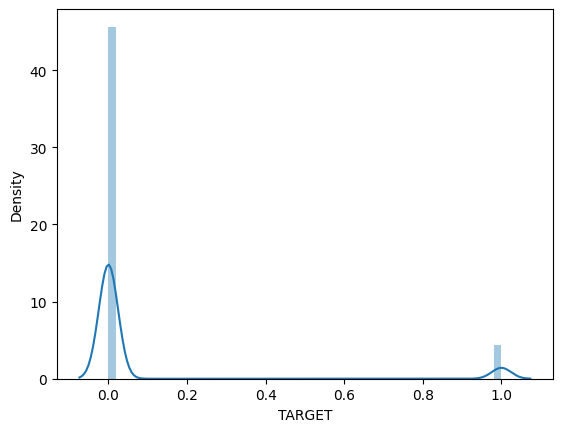

In [13]:
sns.distplot(Y_train)

/tmp/ipykernel_42/336957920.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_test)


<Axes: xlabel='TARGET', ylabel='Density'>

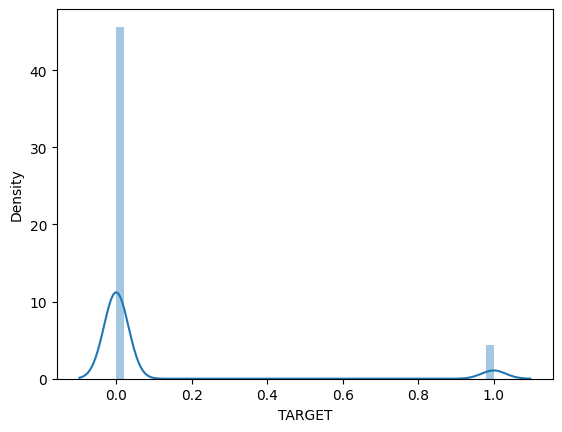

In [15]:
sns.distplot(Y_test)

<h4> Before implementing sampling methods, I will build models on the original data using the threshold moving.(Blog 4)</h4><br>
<p> We'll begin with logistic regression before trying ensemble algorithms like HistGradientBoosting or XGBoost.</p>

In [16]:
from sklearn.linear_model import LogisticRegression

<h4><b> Choosing the right evaluation metric </b></h4>
<a href="https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/#:~:text=Precision-Recall%20Metrics&text=The%20F-Measure%20is%20a%20popular%20metric%20for%20imbalanced%20classification."> Link to the blog. </a> The image posted below serves as a guide to choosing the right evaluation metric for an imbalanced classification task.

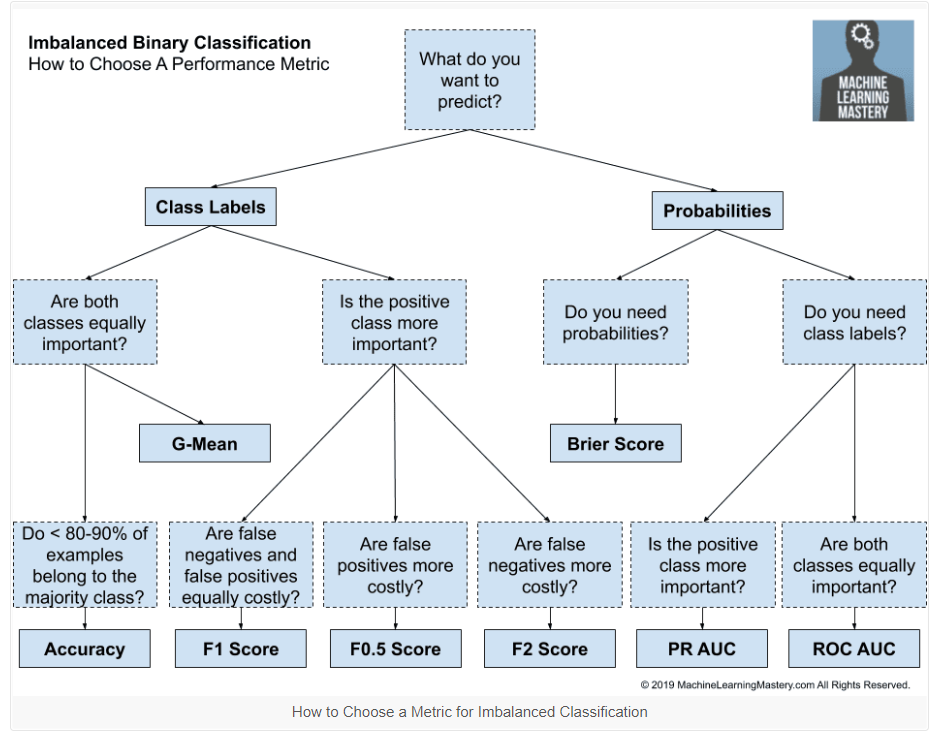

<h4> Using the above flowchart as reference, I will be using PR AUC and F2 score as metrics. </h4>

In [17]:
def display_confusion_matrix(Y_test:pd.DataFrame, Y_pred:pd.DataFrame)->None:
    plt.figure(figsize=(12,6))
    cm = metrics.confusion_matrix(Y_test,Y_pred,labels=[1,0])
    cm_display = metrics.ConfusionMatrixDisplay(cm,display_labels=[1,0])
    cm_display.plot()
    plt.show()

In [18]:
def plot_precision_recall_curve(Y_test:pd.DataFrame, Y_pred:pd.DataFrame, is_threshold_used=False, 
                   best_threshold_ix=None, precision_threshold=None, recall_threshold=None)->None:
    plt.figure(figsize=(12,4))
    no_skill = len(Y_test[Y_test==1]) / len(Y_test)
    plt.plot([0,1],[no_skill,no_skill],linestyle='--',label='No Skill')
    #plt.plot([1,0], [1,1], linestyle='--', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    if is_threshold_used:
        precision,recall = precision_threshold,recall_threshold
        plt.scatter(recall[best_threshold_ix],precision[best_threshold_ix],marker='o',color='black',label='Best')
    else:
        precision,recall,_ = metrics.precision_recall_curve(Y_test,Y_pred)

    auc_score = metrics.auc(recall,precision)
        
    plt.plot(recall, precision, marker='.', label=f'AUC = {auc_score}')
    plt.legend()
    plt.show()

In [153]:
def evaluate_model(Y_test:pd.DataFrame, Y_pred_proba:pd.DataFrame, Y_pred_label:pd.DataFrame,
                   is_threshold_used=False, is_balanced=False)->None:
    if not is_balanced:
        print(imb_metrics.classification_report_imbalanced(Y_test,Y_pred_label))
    else:
        print(metrics.classification_report(Y_test,Y_pred_label))
    weighted_recall = metrics.recall_score(Y_test,Y_pred_label,average='weighted')
    print(f'Weighted Recall :{weighted_recall}')
    if not is_threshold_used:
        plot_precision_recall_curve(Y_test,Y_pred_proba)
    display_confusion_matrix(Y_test,Y_pred_label)

In [20]:
def build_model(classifier, X_train:pd.DataFrame, Y_train:pd.DataFrame, X_test: pd.DataFrame, 
                Y_test:pd.DataFrame)-> None:
    classifier.fit(X_train,Y_train)
    Y_pred_proba = classifier.predict_proba(X_test)[:,1]
    Y_pred_label = classifier.predict(X_test)
    return (classifier,Y_pred_proba,Y_pred_label)

In [21]:
logit_clf_balanced = LogisticRegression(solver='newton-cholesky',class_weight='balanced',max_iter=2500)

In [22]:
logit_clf_balanced,Y_pred_logit_proba,Y_pred_logit_label = build_model(logit_clf_balanced,X_train,Y_train,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.62      0.64      0.75      0.63      0.39     45407
          1       0.14      0.64      0.62      0.23      0.63      0.39      4337

avg / total       0.88      0.62      0.63      0.70      0.63      0.39     49744

Weighted Recall :0.6193510775168865


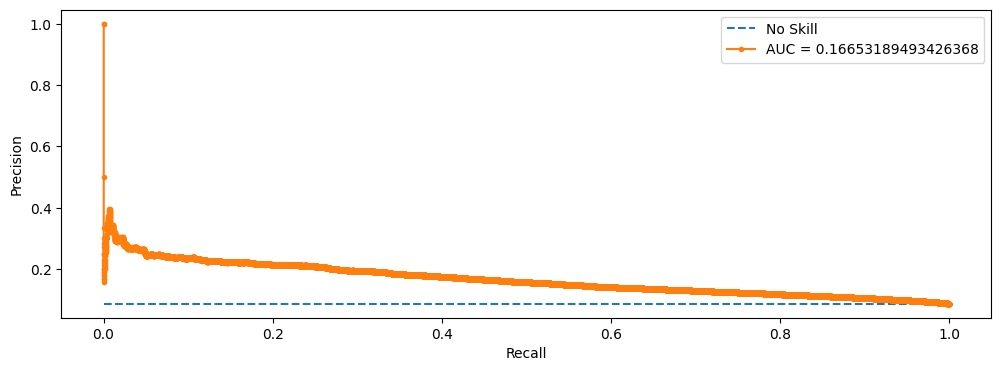

<Figure size 1200x600 with 0 Axes>

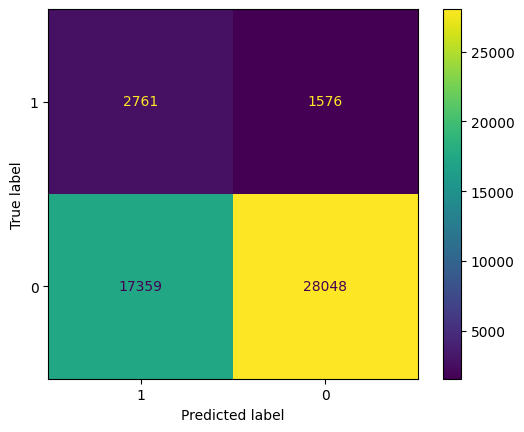

In [23]:
evaluate_model(Y_test,Y_pred_logit_proba,Y_pred_logit_label)

<h4> Tuning the classifier </h4>

In [24]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        #'penalty':trial.suggest_categorical('penalty',['l1','l2','elasticnet','none']),
        'C':trial.suggest_float('C',0.001,2),
        'tol':trial.suggest_float('tol' , 1e-6 , 1e-2),
        'class_weight':'balanced',
        'max_iter':2000,
        'n_jobs':-1
    }
    logit_clf_tuned = LogisticRegression(**param).fit(X_train,Y_train)
    Y_pred_tuned = logit_clf_tuned.predict(X_test)
    f2_score = metrics.fbeta_score(Y_test, Y_pred_tuned, beta=2)
    return f2_score 

In [25]:
study = optuna.create_study(direction = 'maximize')

In [26]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 100)

In [27]:
print('Logistic Regression Best Parameters:',study.best_trial.params)
print('Best F2 score:',study.best_value)

Logistic Regression Best Parameters: {'C': 1.8845992007971086, 'tol': 0.003378375760575394}
Best F2 score: 0.37361660877292197


best_params_logit = study.best_trial.params
best_params_logit['solver'] = 'newton-cholesky'
best_params_logit['class_weight'] = 'balanced'

In [26]:
best_params_logit = {'C': 1.8845992007971086, 'tol': 0.003378375760575394,'class_weight':'balanced','solver':'newton-cholesky'}

In [27]:
logit_clf_tuned = LogisticRegression(**best_params_logit)

In [28]:
logit_clf_tuned,Y_pred_logit_proba_tuned,Y_pred_logit_label_tuned = build_model(logit_clf_tuned,X_train,Y_train,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.62      0.64      0.75      0.63      0.39     45407
          1       0.14      0.64      0.62      0.23      0.63      0.39      4337

avg / total       0.88      0.62      0.64      0.70      0.63      0.39     49744

Weighted Recall :0.6193510775168865


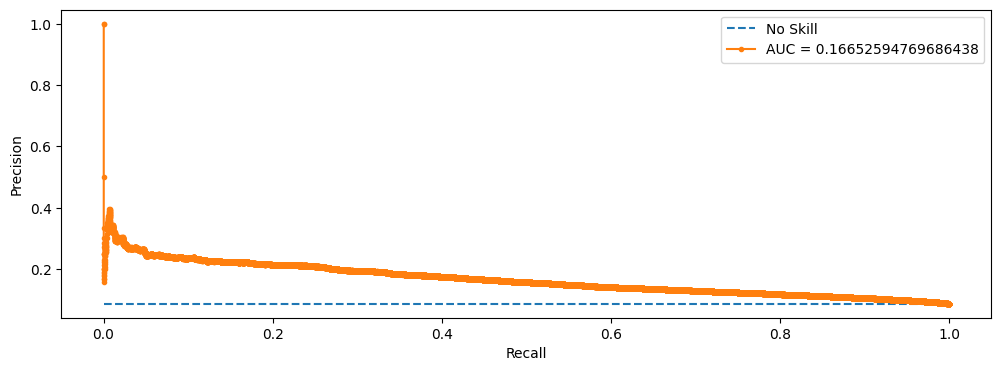

<Figure size 1200x600 with 0 Axes>

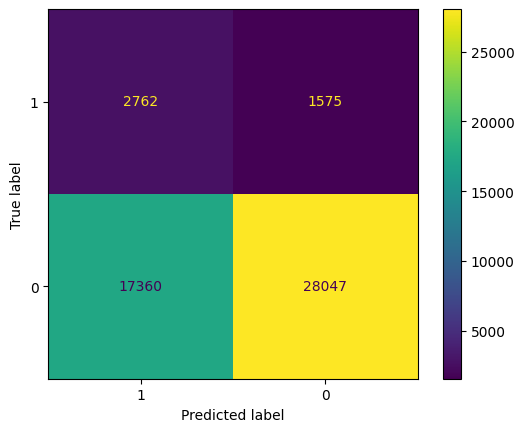

In [29]:
evaluate_model(Y_test,Y_pred_logit_proba_tuned,Y_pred_logit_label_tuned)

<h1> Third Approach - Computing optimal class weights</h1>
<p>  Before sampling, we can predict class probabilities instead of class labels and compute the weights of individual classes by thresholding. <b>The goal is to experiment with different thresholds and assign labels according to the best threshold.</b><br>
    For example, let's assume that the threshold = 0.5.<br> 
    Any probability less than 0.5 would be assigned to class 0 and greater than 0.5 would be class 1. Instead of setting 0.5 as the threshold, we will try different values to see how threshold will return the optimal F1 score.<br><br>
    Additionally, Geometric Mean and  Youden’s J statistic have been used to identify the best threshold value for an ROC curve.<br><br>

Here's a sneak peek into how G-Mean and J Statistic are computed:<br>
> G-Mean = sqrt(Sensitivity * Specificity), where:<br>
>> Sensitivity = True Positives / (True Positives + False Negatives) = True Positive Rate<br>
>> Specificity = True Negatives / (False Positives + True Negatives) = 1 - False Positive Rate<br>
    
> J Statistic = Sensitivity + Specificity – 1, (OR), True Positive Rate - False Positive Rate

For more information, please refer Blogs 4 and 5 with other resources.
</p>

<h3> Optimum threshold for Precision-Recall curve - Steps to follow: </h3>
<p> 
    <ol>
        <li> Split the original dataset into train and test sets. </li>
        <li> Build a classifier and predict probabilities. </li>
        <li> For each threshold, using the Precision-Recall curve, compute AUC. </li>
        <li> Identify the threshold for which AUC score is highest. </li>
    </ol>
</p>

In [30]:
def convert_probs_to_labels(threshold,class_prob):
    return (class_prob>=threshold).astype('int') 

In [31]:
def get_valid_thresholding_metrics(precision,recall):
    f2score = (5*precision*recall)/(4*precision+recall)
    nan_indices = np.argwhere(np.isnan(f2score))
    nan_indices = nan_indices.flatten()
    precision = np.delete(precision,nan_indices)
    recall = np.delete(recall,nan_indices)
    f2score = np.delete(f2score,nan_indices)
    
    return (precision,recall,f2score)

In [32]:
def get_thresholding_metrics(classifier,predicted_probs):
    #Y_pred_tuned_probs = classifier.predict_proba(X_test)
    #predicted_probs = Y_pred_tuned_probs[:,1]
    precision,recall,thresholds = metrics.precision_recall_curve(Y_test,predicted_probs)
    precision,recall,f2score = get_valid_thresholding_metrics(precision,recall)
    
    return (precision,recall,f2score,thresholds)

In [33]:
precision,recall,f2_score,thresholds = get_thresholding_metrics(logit_clf_tuned,Y_pred_logit_proba_tuned)

In [34]:
ix = np.argmax(f2_score)
best_threshold = thresholds[ix]
best_f2_score = f2_score[ix]
print('Best Threshold=%f, F2-Score=%.3f' % (best_threshold, best_f2_score))

Best Threshold=0.452209, F2-Score=0.375


In [35]:
Y_pred_optimal_labels_logit = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_logit_proba_tuned))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.50      0.74      0.66      0.61      0.37     45407
          1       0.13      0.74      0.50      0.21      0.61      0.38      4337

avg / total       0.88      0.53      0.72      0.62      0.61      0.37     49744

Weighted Recall :0.5255106143454487


<Figure size 1200x600 with 0 Axes>

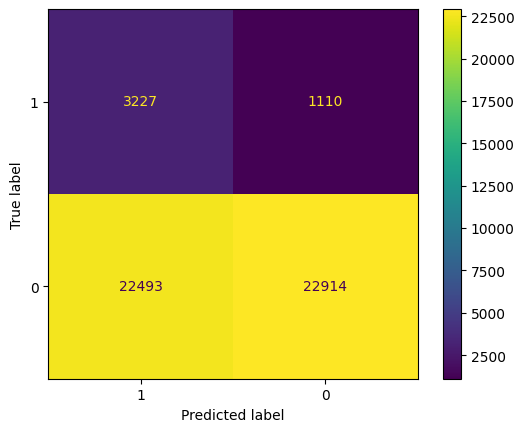

In [36]:
evaluate_model(Y_test,Y_pred_logit_proba_tuned,Y_pred_optimal_labels_logit,True)

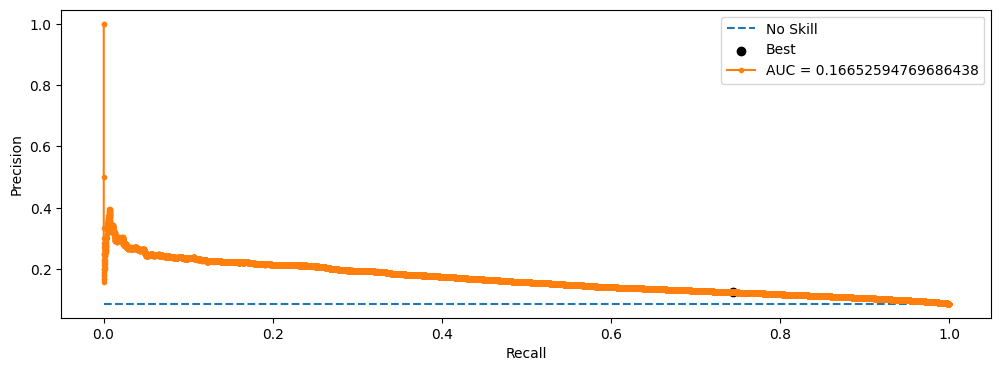

In [37]:
plot_precision_recall_curve(Y_test,Y_pred_logit_proba_tuned,True,ix,precision,recall)

<h3> Optimum threshold - Direct calculation </h3>

In [41]:
def compute_optimal_threshold(predicted_probs,Y_test):
    best_f2_score = -np.inf
    best_threshold = -np.inf
    for threshold in np.arange(0,1,0.001):
        Y_pred_threshold = convert_probs_to_labels(threshold,predicted_probs)
        f2_score = metrics.fbeta_score(Y_test,Y_pred_threshold,beta=2)
        if f2_score > best_f2_score:
            best_f2_score = f2_score 
            best_threshold = threshold    
    
    return (best_f2_score, best_threshold)

In [42]:
best_f2_score, best_threshold = compute_optimal_threshold(Y_pred_logit_proba_tuned,Y_test)

In [43]:
best_threshold,best_f2_score

(0.452, 0.37441407156448697)

In [44]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_logit_proba_tuned))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.50      0.74      0.66      0.61      0.37     45407
          1       0.13      0.74      0.50      0.21      0.61      0.38      4337

avg / total       0.88      0.52      0.72      0.62      0.61      0.37     49744

Weighted Recall :0.5249879382438083


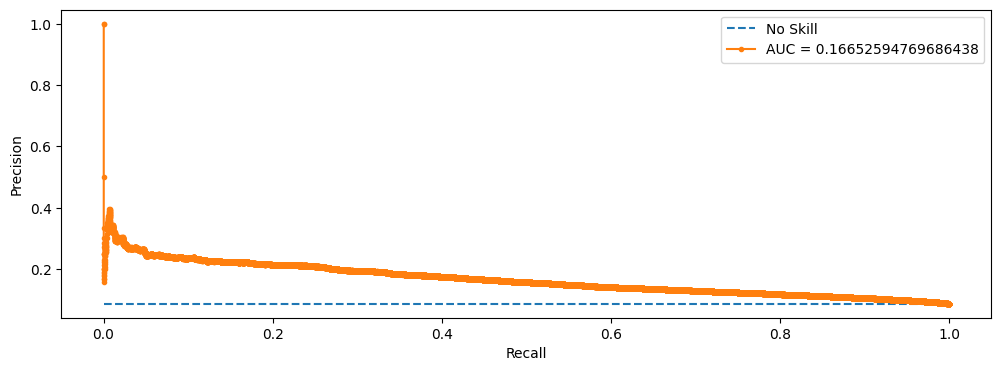

<Figure size 1200x600 with 0 Axes>

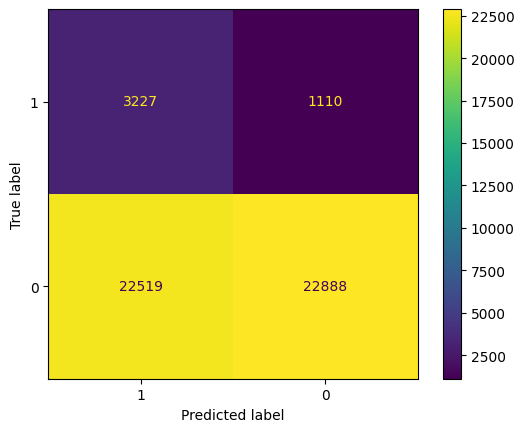

In [45]:
evaluate_model(Y_test,Y_pred_logit_proba_tuned,Y_pred_best_threshold)

<p>
    <h1> Logistic Regression observations:</h1><br>
    <ul>
        <li> Totally, there were 4 attempts to build, evaluate and improve the model. </li>
        <li> Both the tuned classifier and ROC threshold models were superior to the base model.</li>
        <li> Although the AUC score for the direct threshold approach is not as high as the ROC thresholding method, there is a marked difference in identifying false positives. Yet, for this problem statement, it is essential to correctly identify false negatives, as a potential loan defaulting applicant should be more accurately flagged by the model.</li>
    </ul>
    <b>Now, let's build ensemble models like HistGradientBoostingClassifier and XGBoost.</b>
</p>
        

In [46]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [47]:
hgb_clf = HistGradientBoostingClassifier(class_weight='balanced')

In [48]:
hgb_clf,Y_pred_hgb_proba,Y_pred_hgb_labels = build_model(hgb_clf,X_train,Y_train,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.67      0.62      0.78      0.64      0.41     45407
          1       0.15      0.62      0.67      0.24      0.64      0.41      4337

avg / total       0.88      0.66      0.62      0.74      0.64      0.41     49744

Weighted Recall :0.6638589578642651


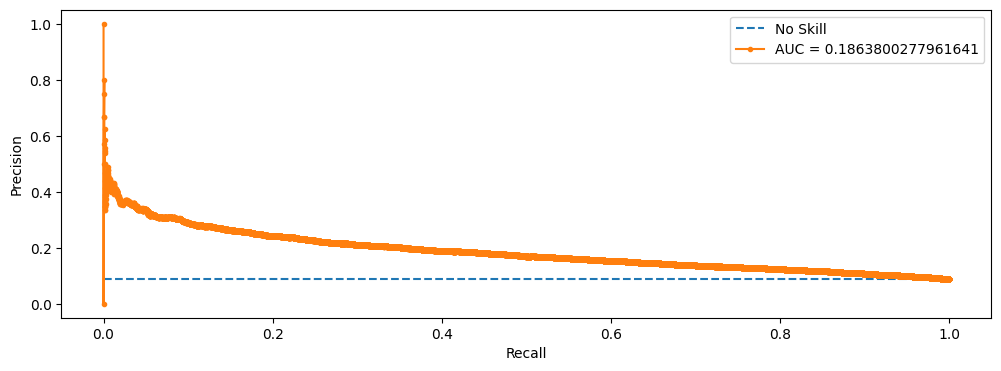

<Figure size 1200x600 with 0 Axes>

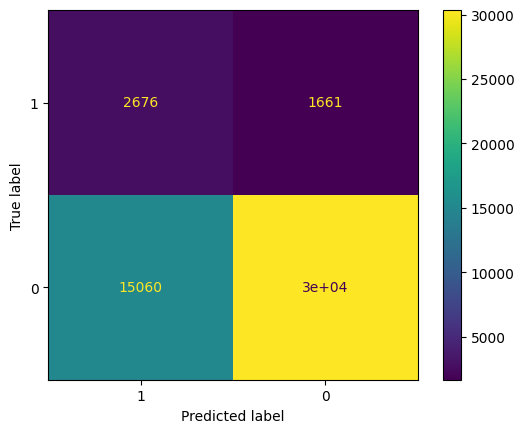

In [49]:
evaluate_model(Y_test,Y_pred_hgb_proba,Y_pred_hgb_labels)

<h3> Tuning the HistGradientBoosting classifier </h3>

In [50]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        'learning_rate':trial.suggest_float('learning_rate',1e-3,1),
        'max_iter':trial.suggest_int('max_iter',100,500),
        'max_depth':trial.suggest_int('max_depth',10,1000),
        #'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',10,50),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf',10,100),
        'early_stopping':True,
        'scoring':metrics.make_scorer(metrics.fbeta_score, beta=2),
        'class_weight':'balanced'
    }
    hgb_clf_tuned = HistGradientBoostingClassifier(**param).fit(X_train,Y_train)
    #Y_pred_tuned = hgb_clf_tuned.predict_proba(X_test)[:,1]
    #precision,recall,_ = metrics.precision_recall_curve(Y_test,Y_pred_tuned)
    #auc_score = metrics.auc(recall,precision)
    Y_pred_tuned = hgb_clf_tuned.predict(X_test)
    f2_score = metrics.fbeta_score(Y_test,Y_pred_tuned,beta=2)
    return f2_score 
    
    #return auc_score 

In [51]:
study = optuna.create_study(direction = 'maximize')

In [52]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 100)

In [53]:
print('Hist GB Best Parameters:',study.best_trial.params)
print('Best F2 score:',study.best_value)

Hist GB Best Parameters: {'learning_rate': 0.17417466332162151, 'max_iter': 245, 'max_depth': 713, 'min_samples_leaf': 67}
Best F2 score: 0.3848190890338406


best_params_hgb = study.best_trial.params
best_params_hgb = {'learning_rate': 0.0550952982537752, 'max_iter': 259, 'max_depth': 866, 'max_leaf_nodes': 30, 'min_samples_leaf': 67}
Best AUC score: 0.19049094053488047

best_params_hgb = {'learning_rate': 0.22738957926981865, 'max_iter': 271, 'max_depth': 310, 'min_samples_leaf': 28}
Best F2 score: 0.3845172990280808

In [55]:
best_params_hgb = {'learning_rate': 0.17417466332162151, 'max_iter': 245, 'max_depth': 713, 'min_samples_leaf': 67,'class_weight':'balanced'}

In [54]:
#best_params_hgb = study.best_trial.params
#best_params_hgb['class_weight']='balanced'

In [56]:
hgb_clf_tuned = HistGradientBoostingClassifier(**best_params_hgb)

In [57]:
hgb_clf_tuned,Y_pred_hgb_tuned_proba,Y_pred_hgb_tuned_labels = build_model(hgb_clf_tuned,X_train,Y_train,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.67      0.62      0.78      0.64      0.42     45407
          1       0.15      0.62      0.67      0.24      0.64      0.41      4337

avg / total       0.88      0.66      0.63      0.74      0.64      0.42     49744

Weighted Recall :0.6629945320038597


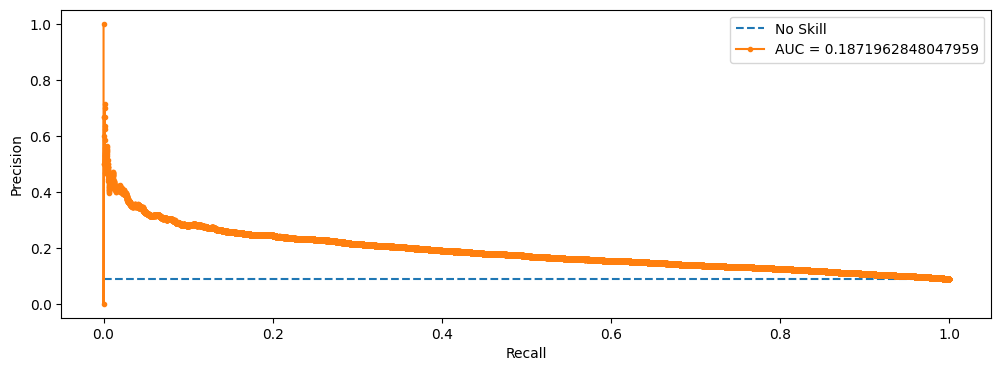

<Figure size 1200x600 with 0 Axes>

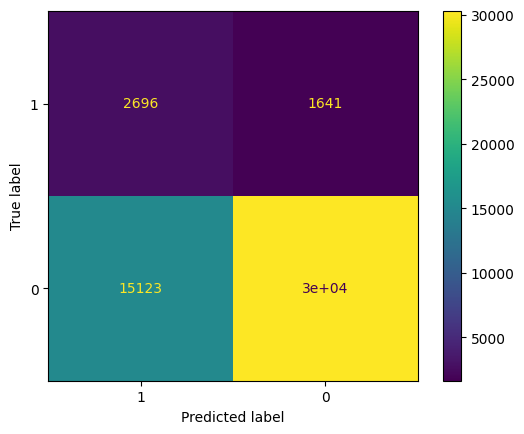

In [58]:
evaluate_model(Y_test,Y_pred_hgb_tuned_proba,Y_pred_hgb_tuned_labels)

<h4> Repeating the thresholding moving process </h4>

<h4> Starting with the optimal ROC threshold computation</h4>

In [59]:
def perform_roc_thresholding(classifier,Y_pred_proba):
    precision,recall,f2_score,thresholds = get_thresholding_metrics(classifier,Y_pred_proba)
    ix = np.argmax(f2_score)
    best_threshold = thresholds[ix]
    best_f2_score = f2_score[ix]
    print('Best Threshold=%f, F2-score=%.3f' % (best_threshold, best_f2_score))
    return (ix,precision,recall)

In [60]:
ix, precision_hgb, recall_hgb = perform_roc_thresholding(hgb_clf_tuned,Y_pred_hgb_tuned_proba)

Best Threshold=0.420375, F2-score=0.387


/tmp/ipykernel_42/2487673585.py:2: RuntimeWarning: invalid value encountered in divide
  f2score = (5*precision*recall)/(4*precision+recall)


In [61]:
Y_pred_optimal_hgb = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_hgb_tuned_proba))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.57      0.71      0.71      0.64      0.40     45407
          1       0.14      0.71      0.57      0.23      0.64      0.41      4337

avg / total       0.88      0.58      0.70      0.67      0.64      0.40     49744

Weighted Recall :0.5812158250241235


<Figure size 1200x600 with 0 Axes>

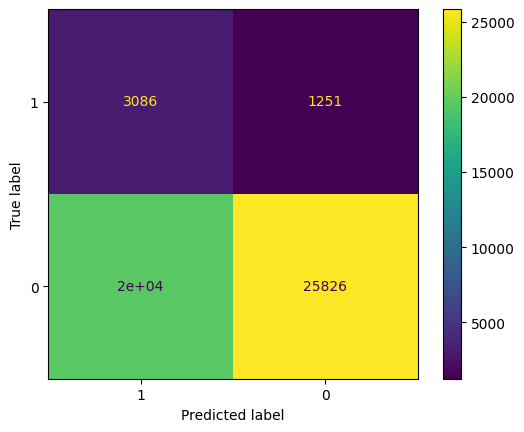

In [62]:
evaluate_model(Y_test,Y_pred_hgb_tuned_proba,Y_pred_optimal_hgb,True)

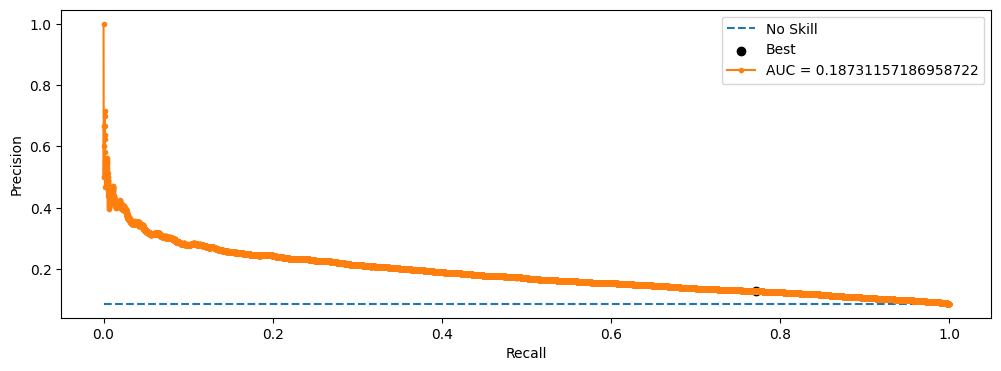

In [63]:
plot_precision_recall_curve(Y_test,Y_pred_hgb_tuned_proba,True,ix,precision_hgb,recall_hgb)

<h4> Threshold computation </h4>

In [65]:
best_f2_score, best_threshold = compute_optimal_threshold(Y_pred_hgb_tuned_proba,Y_test)

In [66]:
best_f2_score, best_threshold

(0.386684832809902, 0.42)

In [67]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_hgb_tuned_proba))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.50      0.77      0.66      0.62      0.38     45407
          1       0.13      0.77      0.50      0.22      0.62      0.40      4337

avg / total       0.89      0.53      0.75      0.62      0.62      0.38     49744

Weighted Recall :0.5256714377613381


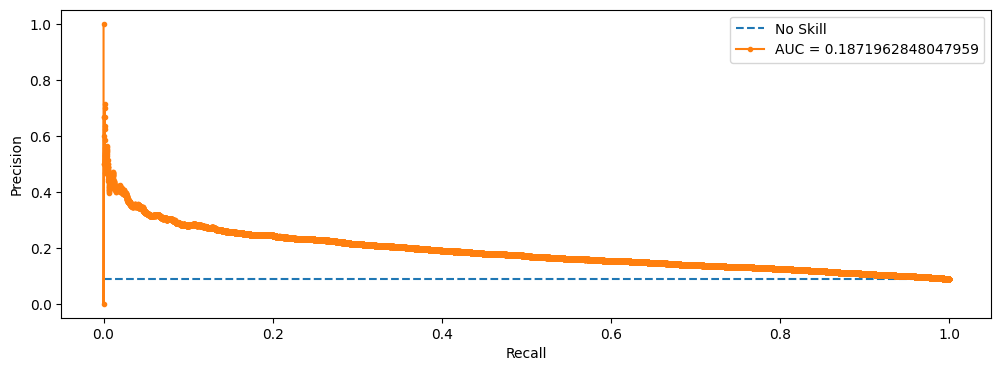

<Figure size 1200x600 with 0 Axes>

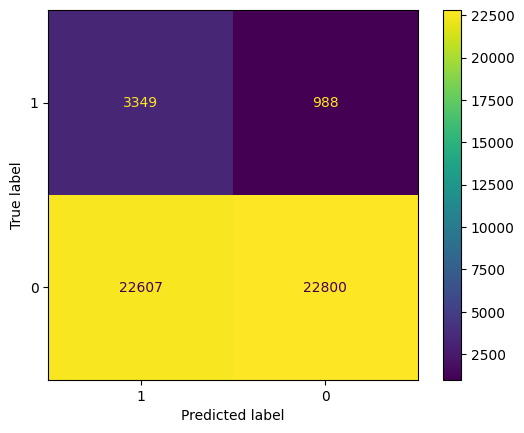

In [68]:
evaluate_model(Y_test,Y_pred_hgb_tuned_proba,Y_pred_best_threshold)

<h1> Approach 4 - Building a calibrated classifier using HistGradientBoosting </h1>

<h4> Plotting the reliability diagram </h4>

In [69]:
X_train_cccv, X_valid_cccv, Y_train_cccv, Y_valid_cccv = model_selection.train_test_split(X_train,Y_train,stratify=Y_train,test_size=0.33,random_state=1)

<h4> Method 1 - Prefitting the model </h4>

In [70]:
hgb_clf_cccv = HistGradientBoostingClassifier(**best_params_hgb).fit(X_train_cccv,Y_train_cccv)

In [71]:
Y_pred_proba_cccv = hgb_clf_cccv.predict_proba(X_valid_cccv)[:,1]

In [72]:
fop, mpv = calibration.calibration_curve(Y_valid_cccv,Y_pred_proba_cccv,normalize=False)

/opt/conda/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


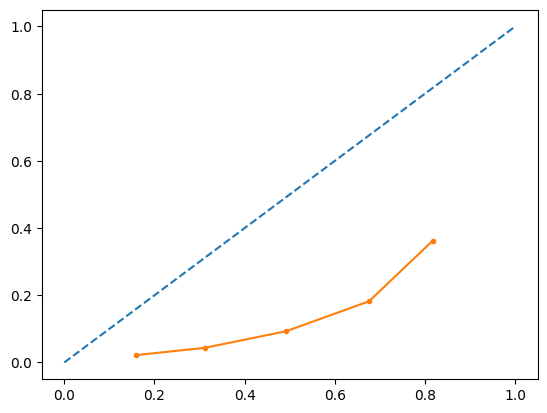

In [73]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.show()

<h4> As we do not get an S-shaped curve, so we can set CalibratedClassifier method to 'isotonic' and try again. </h4>

In [81]:
hgb_clf_cccv = HistGradientBoostingClassifier(**best_params_hgb).fit(X_train_cccv,Y_train_cccv)

In [82]:
calibrated_hgb = calibration.CalibratedClassifierCV(hgb_clf_cccv, method='isotonic', cv='prefit')

In [83]:
calibrated_hgb.fit(X_valid_cccv,Y_valid_cccv)

CalibratedClassifierCV(cv='prefit',
                       estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                learning_rate=0.17417466332162151,
                                                                max_depth=713,
                                                                max_iter=245,
                                                                min_samples_leaf=67),
                       method='isotonic')

In [84]:
Y_pred_calibrated_hgb = calibrated_hgb.predict(X_test)
Y_pred_probs_calibrated_hgb = calibrated_hgb.predict_proba(X_test)[:,1]

In [85]:
fop_calibrated, mpv_calibrated = calibration.calibration_curve(Y_test,Y_pred_probs_calibrated_hgb,normalize=False)

/opt/conda/lib/python3.10/site-packages/sklearn/calibration.py:1000: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


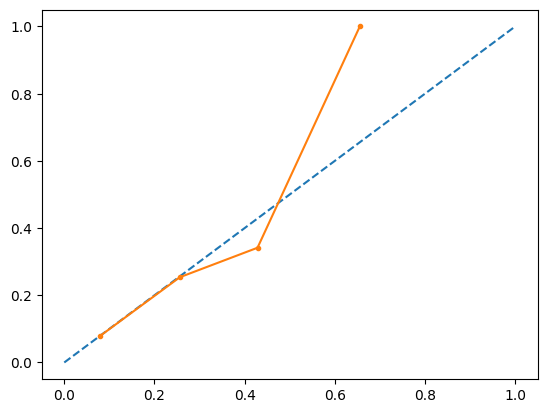

In [86]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')
plt.show()

<h4> From the above plot, it can be seen that the classifier has been calibrated to reflect more accurately, the true likelihood of the class.</h4>

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      1.00      0.00      0.95      0.02      0.00     45407
          1       1.00      0.00      1.00      0.00      0.02      0.00      4337

avg / total       0.92      0.91      0.09      0.87      0.02      0.00     49744

Weighted Recall :0.9128337085879704


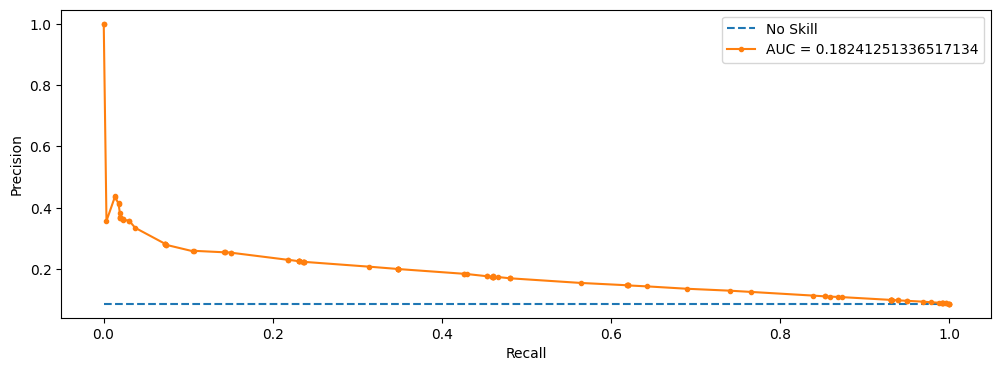

<Figure size 1200x600 with 0 Axes>

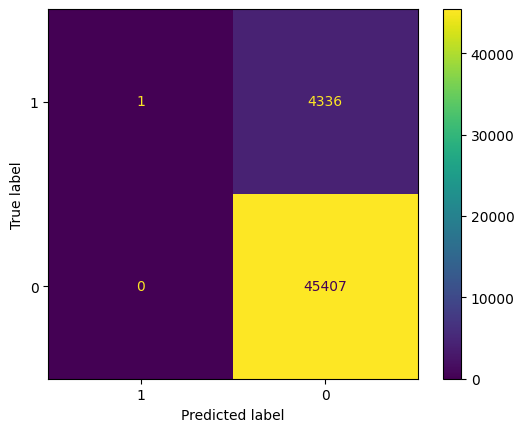

In [87]:
evaluate_model(Y_test,Y_pred_probs_calibrated_hgb,Y_pred_calibrated_hgb)

In [88]:
calibrated_hgb_score = metrics.brier_score_loss(Y_test,Y_pred_probs_calibrated_hgb)

In [89]:
calibrated_hgb_score

0.07623728672685323

In [90]:
ix, precision_calibrated_hgb, recall_calibrated_hgb = perform_roc_thresholding(calibrated_hgb,Y_pred_probs_calibrated_hgb)

Best Threshold=0.075889, F2-score=0.381


                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      1.00      0.00      0.95      0.02      0.00     45407
          1       1.00      0.00      1.00      0.00      0.02      0.00      4337

avg / total       0.92      0.91      0.09      0.87      0.02      0.00     49744

Weighted Recall :0.9128337085879704


<Figure size 1200x600 with 0 Axes>

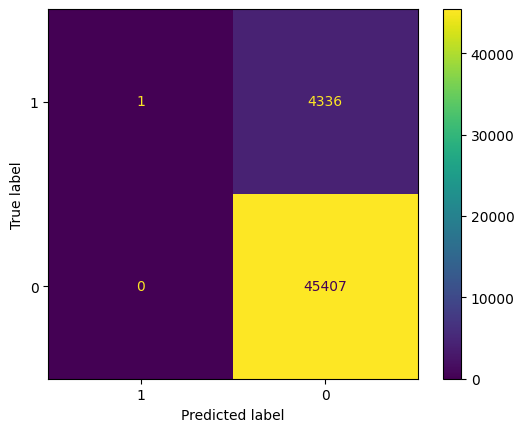

In [91]:
evaluate_model(Y_test,Y_pred_probs_calibrated_hgb,Y_pred_calibrated_hgb,True)

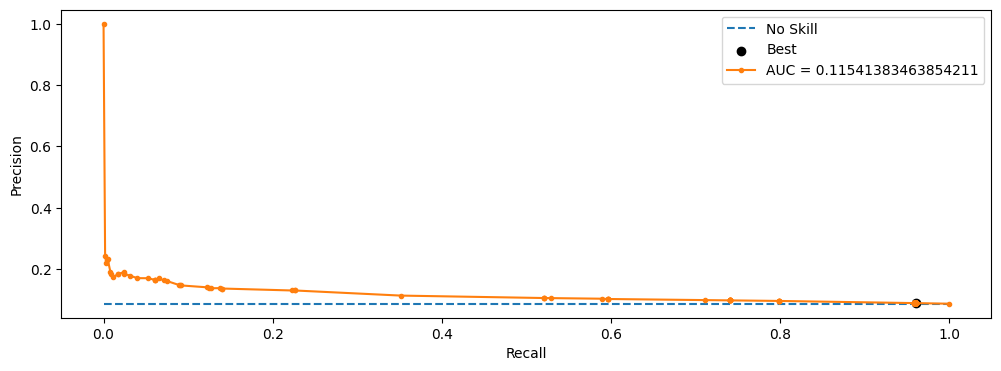

In [83]:
plot_precision_recall_curve(Y_test,Y_pred_probs_calibrated_hgb,True,ix, precision_calibrated_hgb, recall_calibrated_hgb)

In [93]:
best_f2_score, best_threshold = compute_optimal_threshold(Y_pred_probs_calibrated_hgb,Y_test)

In [94]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_probs_calibrated_hgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.53      0.74      0.68      0.62      0.38     45407
          1       0.13      0.74      0.53      0.22      0.62      0.40      4337

avg / total       0.88      0.54      0.72      0.64      0.62      0.38     49744

Weighted Recall :0.5444073657124477


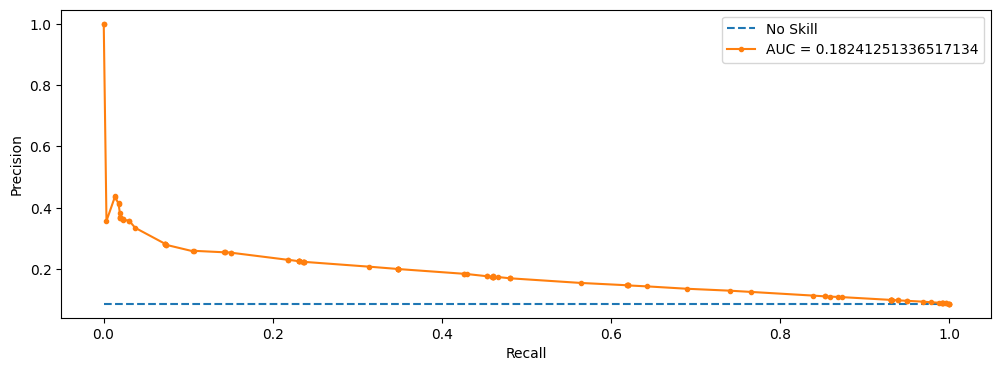

<Figure size 1200x600 with 0 Axes>

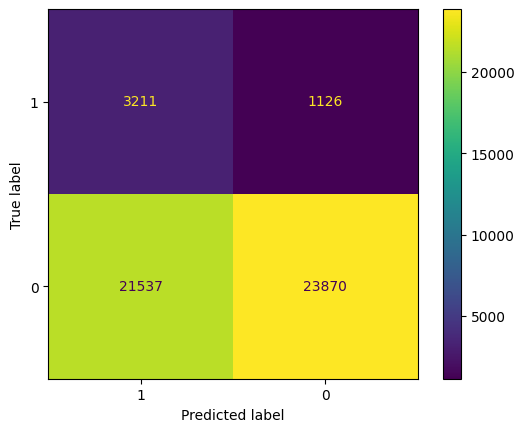

In [95]:
evaluate_model(Y_test,Y_pred_probs_calibrated_hgb,Y_pred_best_threshold)

<p>
    <h1> HistGradientBoosting observations:</h1><br>
    <ul>
        <li> Totally, there were 5 attempts to build, evaluate and improve the model. </li>
        <li> Both the tuned classifier and ROC threshold models were similar to the base model in terms of the confusion matrix. However, ROC threshold method had the highest AUC score of 0.75.</li>
        <li> The AUC score and false negatives for the direct threshold approach were inferior [Lower AUC and higher false negatives] to the ROC thresholding method, but like the logistic regression model, it was able to detect false positives better.</li>
        <li> Lastly, a calibrated classifier was built but did not perform as well as the other models. </li>
    </ul>
    <b>Proceeding to the XGBoost model.</b></p>
</p>
        

<h4> Building the XGBoost classifier </h4>

In [96]:
xgb_clf = XGBClassifier()

In [97]:
xgb_clf, Y_pred_xgb_proba, Y_pred_xgb_labels = build_model(xgb_clf,X_train,Y_train,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      1.00      0.01      0.95      0.08      0.01     45407
          1       0.38      0.01      1.00      0.01      0.08      0.01      4337

avg / total       0.87      0.91      0.09      0.87      0.08      0.01     49744

Weighted Recall :0.9124919588292055


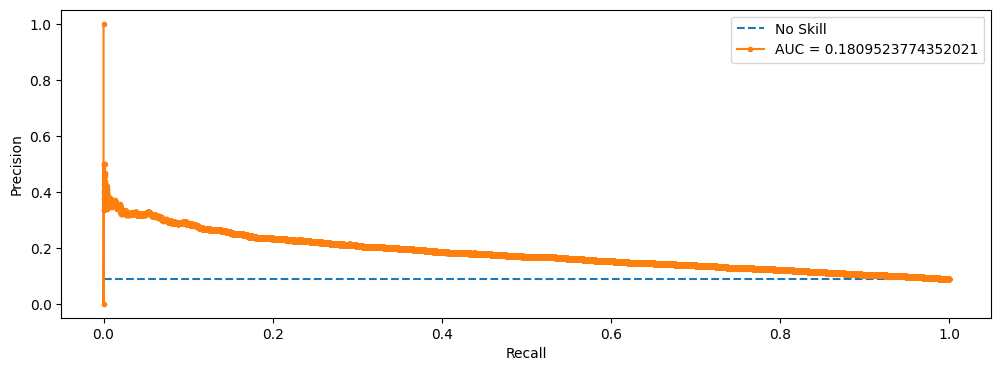

<Figure size 1200x600 with 0 Axes>

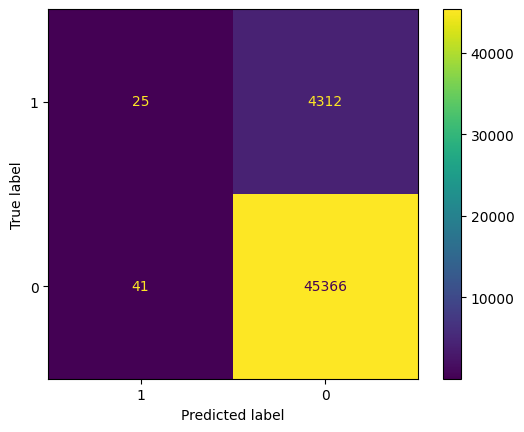

In [98]:
evaluate_model(Y_test,Y_pred_xgb_proba,Y_pred_xgb_labels)

<h4> Tuning the XGBoost classifier </h4>

In [90]:
def objective(trial,X_train,Y_train,X_test,Y_test):
    param = {
        'eta':trial.suggest_float('eta',1e-3,1),
        'lambda':trial.suggest_float('lambda',1e-3,1),
        'alpha':trial.suggest_float('alpha',1e-3,1),
        'max_depth':trial.suggest_int('max_depth',5,50),
        'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart'])
    }
    xgb_clf_tuned = XGBClassifier(**param).fit(X_train,Y_train)
    Y_pred_tuned = xgb_clf_tuned.predict_proba(X_test)[:,1]
    precision,recall,_ = metrics.precision_recall_curve(Y_test,Y_pred_tuned)
    auc_score = metrics.auc(recall,precision)
    return auc_score 

In [91]:
study = optuna.create_study(direction = 'maximize')

In [92]:
study.optimize(lambda trial: objective(trial,X_train,Y_train,X_test,Y_test), n_trials = 50)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:28:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:28:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:29:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:41:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:42:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn

In [93]:
print('XGBoost Best Parameters:',study.best_trial.params)
print('Best AUC score:',study.best_value)

XGBoost Best Parameters: {'eta': 0.8008501864530467, 'lambda': 0.011335371475264238, 'alpha': 0.5380373227893865, 'max_depth': 8, 'booster': 'gblinear'}
Best AUC score: 0.5435931971695078


In [99]:
best_params_xgb = {'eta': 0.8008501864530467, 'lambda': 0.011335371475264238, 'alpha': 0.5380373227893865, 'max_depth': 8, 'booster': 'gblinear'}
# best_params_xgb = study.best_trial.params

In [100]:
xgb_clf_tuned = XGBClassifier(**best_params_xgb)

In [101]:
xgb_clf_tuned,Y_pred_xgb_tuned_proba,Y_pred_xgb_tuned_labels = build_model(xgb_clf_tuned,X_train,Y_train,X_test,Y_test)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:02:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      1.00      0.00      0.95      0.00      0.00     45407
          1       0.00      0.00      1.00      0.00      0.00      0.00      4337

avg / total       0.83      0.91      0.09      0.87      0.00      0.00     49744

Weighted Recall :0.9128136056609842


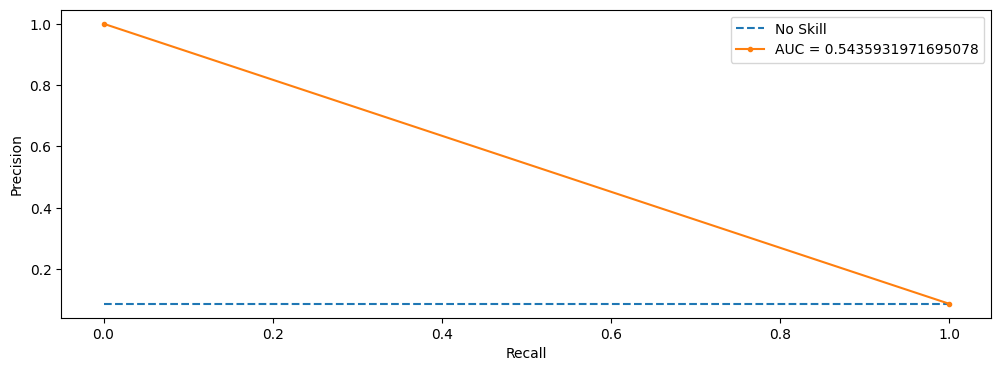

<Figure size 1200x600 with 0 Axes>

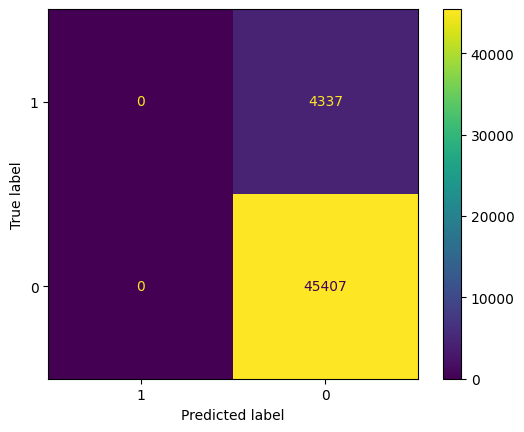

In [102]:
evaluate_model(Y_test,Y_pred_xgb_tuned_proba,Y_pred_xgb_tuned_labels)

<h4> Implementing Precision-Recall AUC score tuning </h4>

In [103]:
precision_xgb,recall_xgb,f2_score_xgb,thresholds_xgb = get_thresholding_metrics(xgb_clf_tuned,Y_pred_xgb_tuned_proba)

In [104]:
ix = np.argmax(f2_score_xgb)
best_threshold = thresholds_xgb[ix]
best_f2_score = f2_score_xgb[ix]
print('Best Threshold=%f, F2-score=%.3f' % (best_threshold, best_f2_score))

Best Threshold=0.087193, F2-score=0.323


In [105]:
Y_pred_optimal_xgb = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_xgb_tuned_proba))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00     45407
          1       0.09      1.00      0.00      0.16      0.00      0.00      4337

avg / total       0.01      0.09      0.91      0.01      0.00      0.00     49744

Weighted Recall :0.08718639433901576


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1200x600 with 0 Axes>

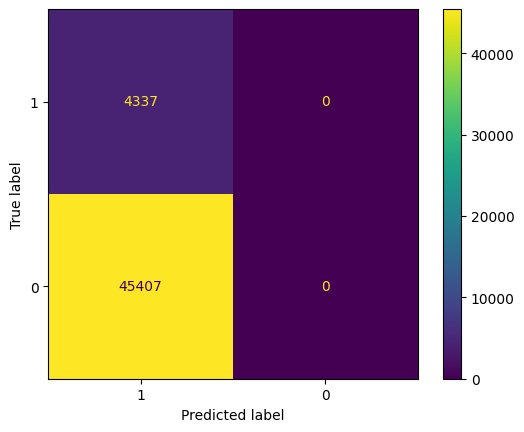

In [106]:
evaluate_model(Y_test,Y_pred_xgb_tuned_proba,Y_pred_optimal_xgb,True)

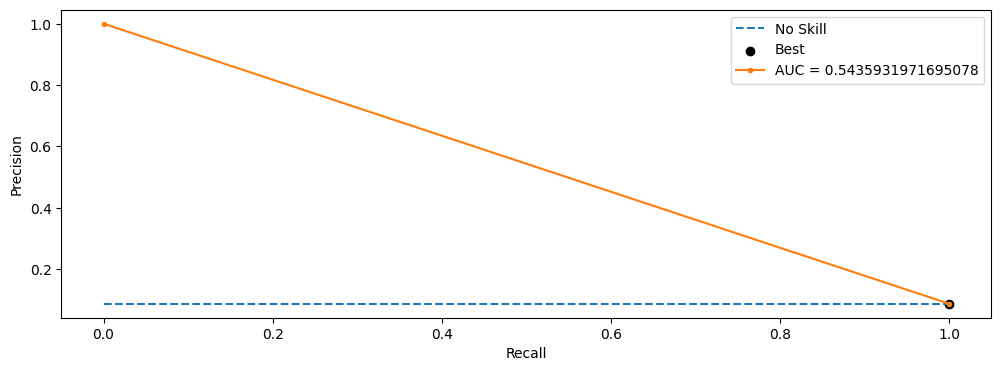

In [107]:
plot_precision_recall_curve(Y_test,Y_pred_xgb_tuned_proba,True,ix,precision_xgb,recall_xgb)

<h4> Direct optimal threshold computation </h4>

In [108]:
best_f2_score, best_threshold = compute_optimal_threshold(Y_pred_xgb_tuned_proba,Y_test)

In [109]:
Y_pred_best_threshold = pd.Series(convert_probs_to_labels(best_threshold,Y_pred_xgb_tuned_proba))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00     45407
          1       0.09      1.00      0.00      0.16      0.00      0.00      4337

avg / total       0.01      0.09      0.91      0.01      0.00      0.00     49744

Weighted Recall :0.08718639433901576


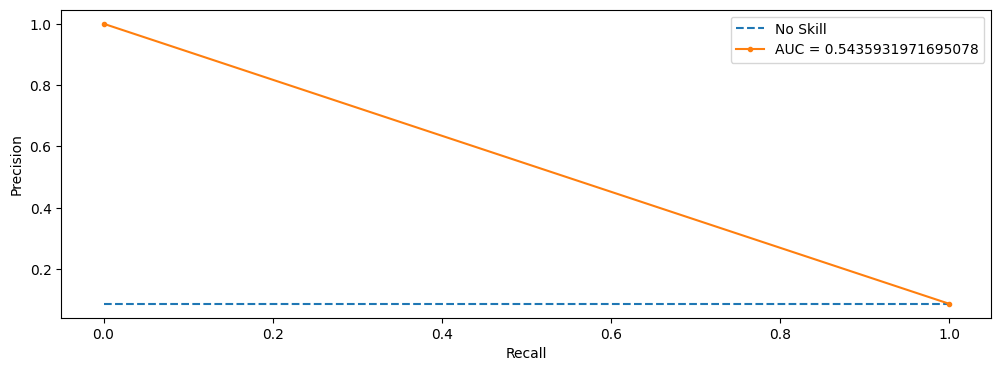

<Figure size 1200x600 with 0 Axes>

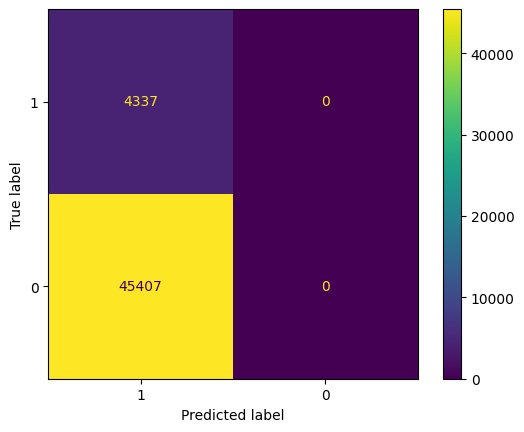

In [110]:
evaluate_model(Y_test,Y_pred_xgb_tuned_proba,Y_pred_best_threshold)

<h3> Approach 2 - Using StratifiedKFold</h3>

In [164]:
X['Fold'] = -1

In [165]:
stratified_kfold = model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
for fold,(train_idx,validation_idx) in enumerate(stratified_kfold.split(X,Y)):
    X.loc[validation_idx,"Fold"] = fold

In [168]:
X.Fold.value_counts()

Fold
5    24872
1    24872
4    24872
3    24872
0    24872
2    24872
8    24871
9    24871
6    24871
7    24871
Name: count, dtype: int64

In [169]:
for fold in range(10):
    X_train = X[X.Fold!=fold].reset_index(drop=True)
    X_test = X[X.Fold==fold].reset_index(drop=True)
    
    X_train, X_test = perform_scaling(X_train, X_test)

<h3><b><u>Summary so far</u></b></h3>
<p>Three models have been built, LogisticRegression, HistGradientBoost and XGBoost. For each classifier, a baseline model, tuned model and thresholding has been performed. Also, calibrated classifiers have been built with both the boosting models.<br> Now it is time to try out sampling techniques starting with oversampling. </p>

<h1> Sampling Techniques - Applied only after splitting the data into train and test sets </h1>
<p> There are two main methods to perform sampling - Undersampling and Oversampling.<br>
    <b><u>Undersampling:</u></b>  Here, records of the majority class are randomly selected to match those of the minority class. <br>
    <b>Techniques -</b> RandomUnderSampler, TomekLinks, NearMiss<br>
    <b>Cons - Loss of information.</b><br><br>
    <b><u>Oversampling:</u></b>  Here, records of the minority class are duplicated/synthetically generated to match those of the majority class. <br>
    <b>Techniques -</b> RandomOverSampler, SMOTE<br>
    <b>Cons - Overfitting.</b><br>
    

<h4> Method 1 - Random Over Sampler </h4>

In [116]:
random_over_sampler = over_sampling.RandomOverSampler()

In [117]:
X_train_ros, Y_train_ros = random_over_sampler.fit_resample(X_train,Y_train)

In [118]:
Y_train_ros.value_counts()

TARGET
0    181623
1    181623
Name: count, dtype: int64

In [119]:
logit_clf_ros = LogisticRegression()

In [121]:
logit_clf_ros, Y_pred_logit_ros_probs, Y_pred_logit_ros_label = build_model(logit_clf_ros,X_train_ros,Y_train_ros,X_test,Y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.62      0.64      0.75      0.63      0.39     45407
          1       0.14      0.64      0.62      0.22      0.63      0.39      4337

avg / total       0.88      0.62      0.63      0.70      0.63      0.39     49744

Weighted Recall :0.6179639755548407


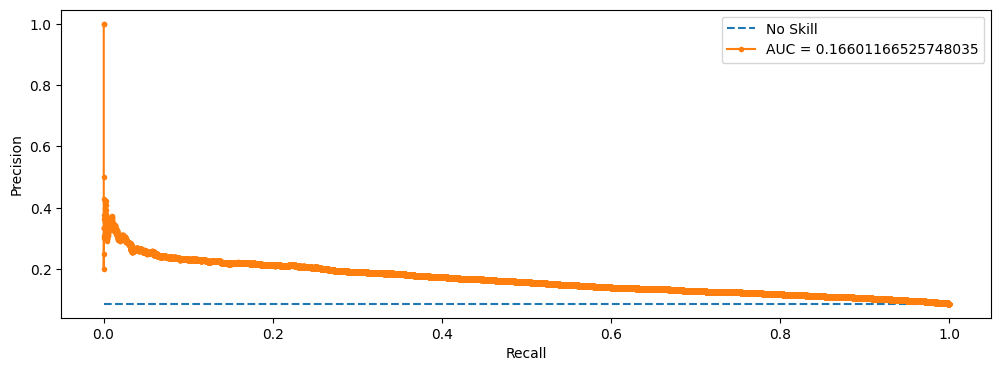

<Figure size 1200x600 with 0 Axes>

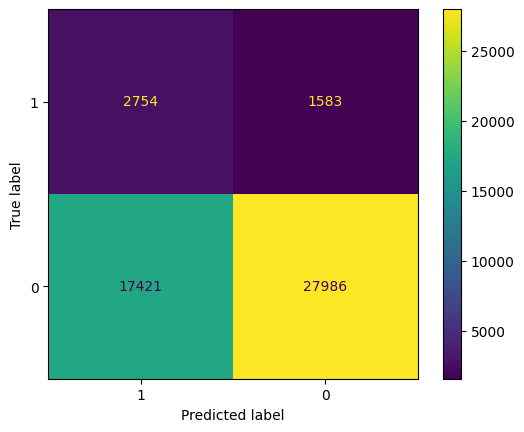

In [122]:
evaluate_model(Y_test,Y_pred_logit_ros_probs,Y_pred_logit_ros_label,False,True)

In [123]:
hgb_clf_ros = HistGradientBoostingClassifier()

In [124]:
hgb_clf_ros, Y_pred_hgb_ros_probs, Y_pred_hgb_ros_label = build_model(hgb_clf_ros,X_train_ros,Y_train_ros,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.67      0.62      0.79      0.64      0.42     45407
          1       0.15      0.62      0.67      0.24      0.64      0.41      4337

avg / total       0.88      0.67      0.62      0.74      0.64      0.42     49744

Weighted Recall :0.6661305886137021


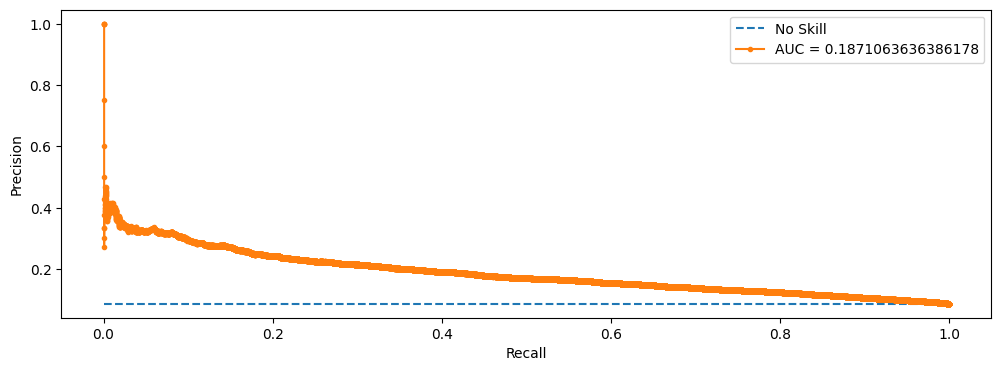

<Figure size 1200x600 with 0 Axes>

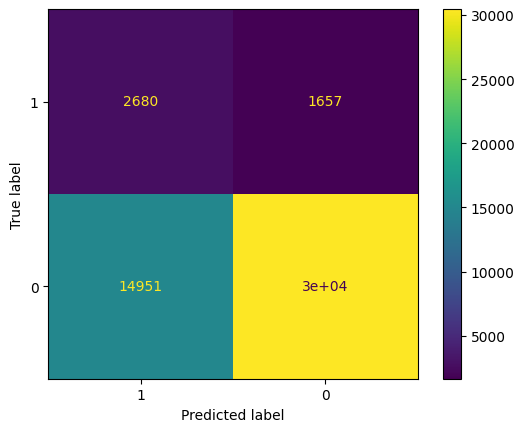

In [125]:
evaluate_model(Y_test,Y_pred_hgb_ros_probs,Y_pred_hgb_ros_label,False,True)

In [126]:
xgb_clf_ros = XGBClassifier()

In [127]:
xgb_clf_ros, Y_pred_xgb_ros_probs, Y_pred_xgb_ros_label = build_model(xgb_clf_ros,X_train_ros,Y_train_ros,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.71      0.56      0.81      0.63      0.40     45407
          1       0.16      0.56      0.71      0.24      0.63      0.39      4337

avg / total       0.88      0.70      0.57      0.76      0.63      0.40     49744

Weighted Recall :0.697953522032808


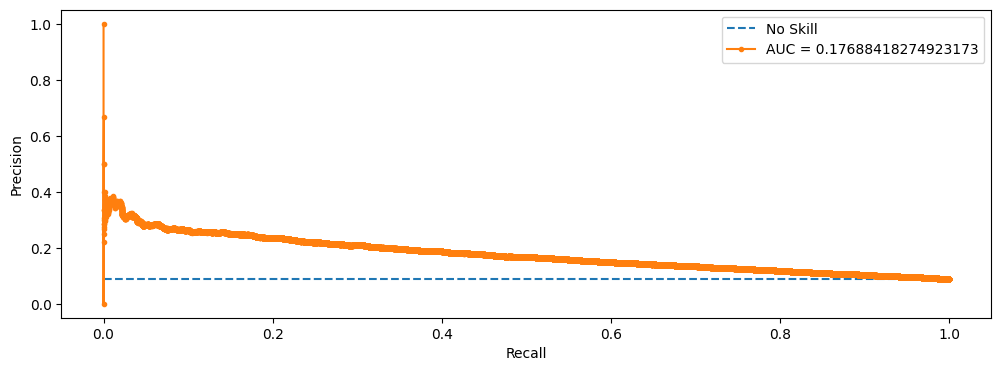

<Figure size 1200x600 with 0 Axes>

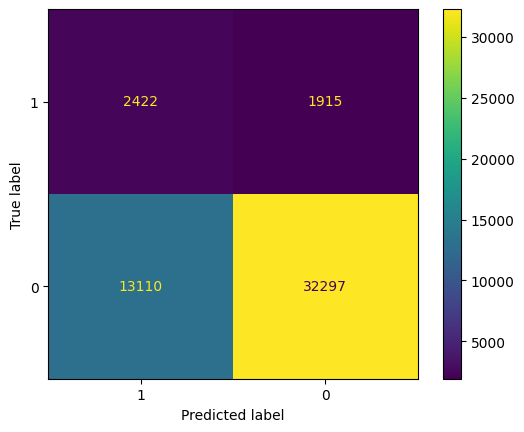

In [128]:
evaluate_model(Y_test,Y_pred_xgb_ros_probs, Y_pred_xgb_ros_label,False,True)

<h4> Method 2 - SMOTE </h4>

In [129]:
smote = over_sampling.SMOTE()

In [130]:
X_train_smote, Y_train_smote = smote.fit_resample(X_train,Y_train)

In [131]:
logit_clf_smote = LogisticRegression()

In [132]:
logit_clf_smote, Y_pred_logit_smote_probs, Y_pred_logit_smote_label = build_model(logit_clf_smote,X_train_smote,Y_train_smote,X_test,Y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.70      0.41      0.80      0.54      0.30     45407
          1       0.12      0.41      0.70      0.18      0.54      0.28      4337

avg / total       0.85      0.68      0.43      0.74      0.54      0.29     49744

Weighted Recall :0.6759408169829527


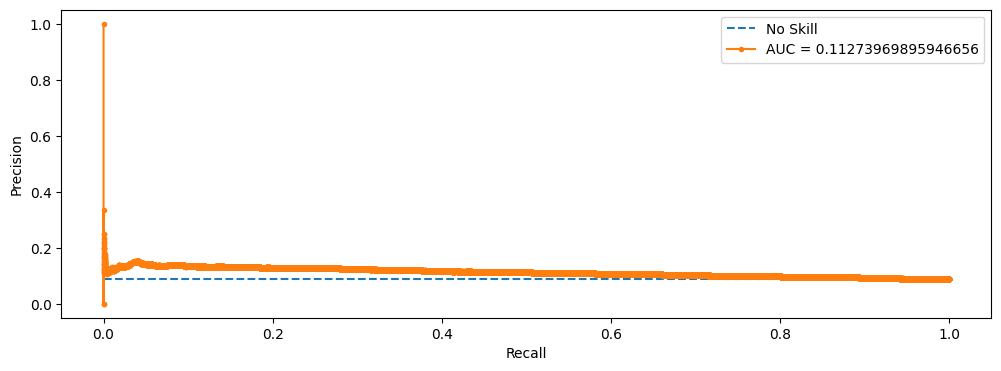

<Figure size 1200x600 with 0 Axes>

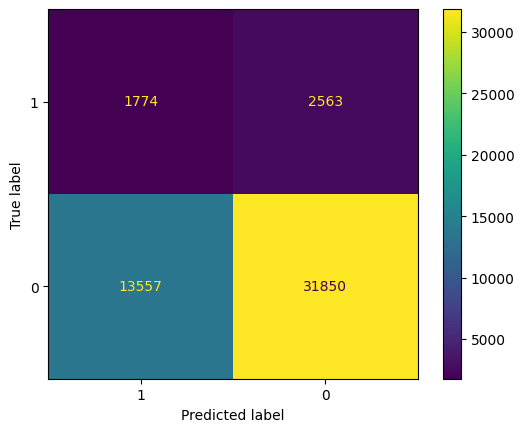

In [133]:
evaluate_model(Y_test,Y_pred_logit_smote_probs, Y_pred_logit_smote_label,False,True)

In [134]:
hgb_clf_smote = HistGradientBoostingClassifier()

In [135]:
hgb_clf_smote,Y_pred_hgb_smote_probs, Y_pred_hgb_smote_label = build_model(hgb_clf_smote,X_train_smote,Y_train_smote,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      1.00      0.00      0.95      0.04      0.00     45407
          1       0.29      0.00      1.00      0.00      0.04      0.00      4337

avg / total       0.86      0.91      0.09      0.87      0.04      0.00     49744

Weighted Recall :0.9126125763911226


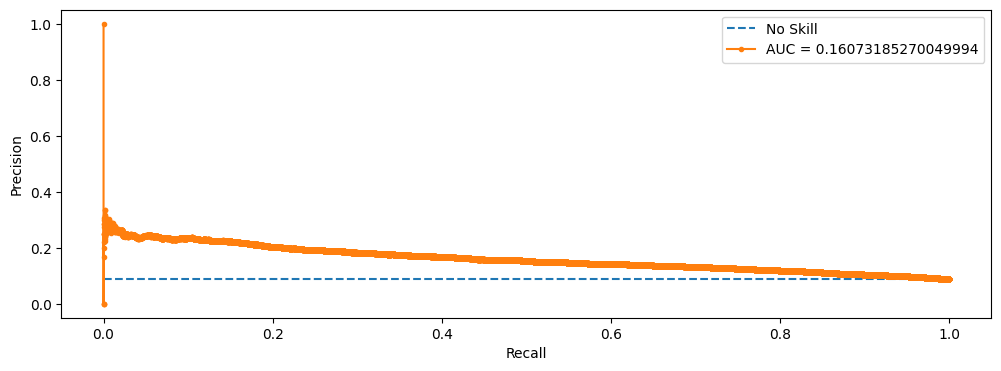

<Figure size 1200x600 with 0 Axes>

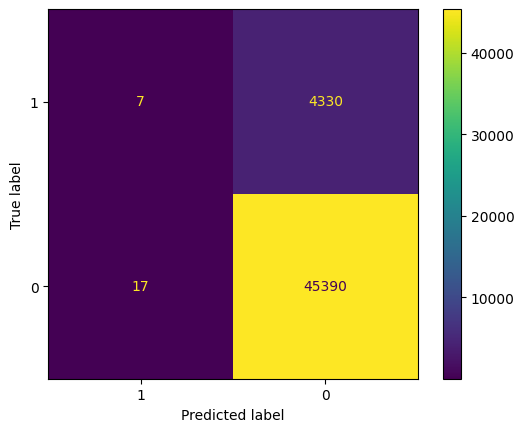

In [136]:
evaluate_model(Y_test,Y_pred_hgb_smote_probs, Y_pred_hgb_smote_label,False,True)

In [137]:
xbg_smote = XGBClassifier()

In [138]:
xbg_smote,Y_pred_xgb_smote_probs, Y_pred_xgb_smote_label = build_model(xbg_smote,X_train_smote,Y_train_smote,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      1.00      0.01      0.95      0.07      0.01     45407
          1       0.28      0.01      1.00      0.01      0.07      0.00      4337

avg / total       0.86      0.91      0.09      0.87      0.07      0.01     49744

Weighted Recall :0.9120697973624959


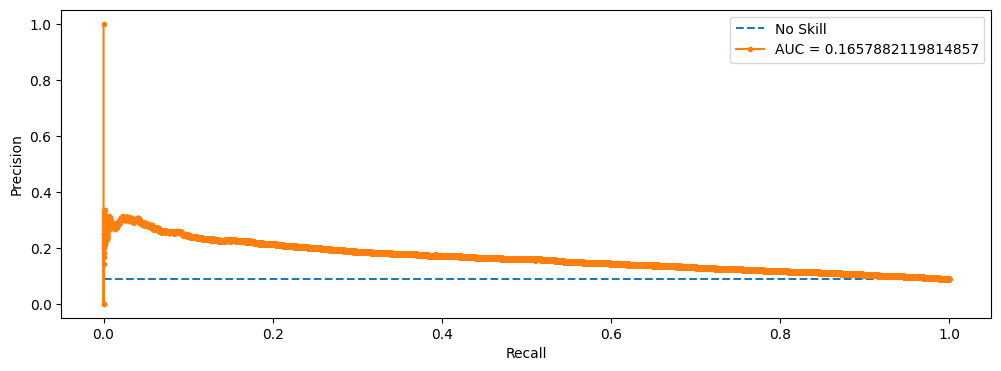

<Figure size 1200x600 with 0 Axes>

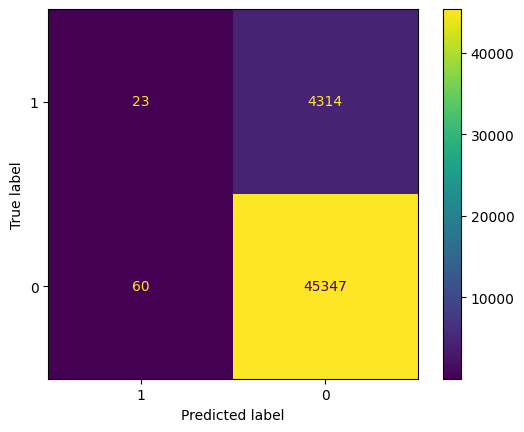

In [139]:
evaluate_model(Y_test,Y_pred_xgb_smote_probs, Y_pred_xgb_smote_label,False,True)

<h4> Method 3 - ADASYN </h4>

In [154]:
adasyn = over_sampling.ADASYN()

In [155]:
X_train_adasyn, Y_train_adasyn = smote.fit_resample(X_train,Y_train)

In [156]:
logit_clf_adasyn = LogisticRegression()

In [157]:
logit_clf_adasyn, Y_pred_logit_adasyn_probs,Y_pred_logit_adasyn_labels = build_model(logit_clf_adasyn,X_train_adasyn,Y_train_adasyn,X_test,Y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.93      0.70      0.80     45407
           1       0.12      0.41      0.18      4337

    accuracy                           0.68     49744
   macro avg       0.52      0.56      0.49     49744
weighted avg       0.85      0.68      0.74     49744

Weighted Recall :0.6767650369893856


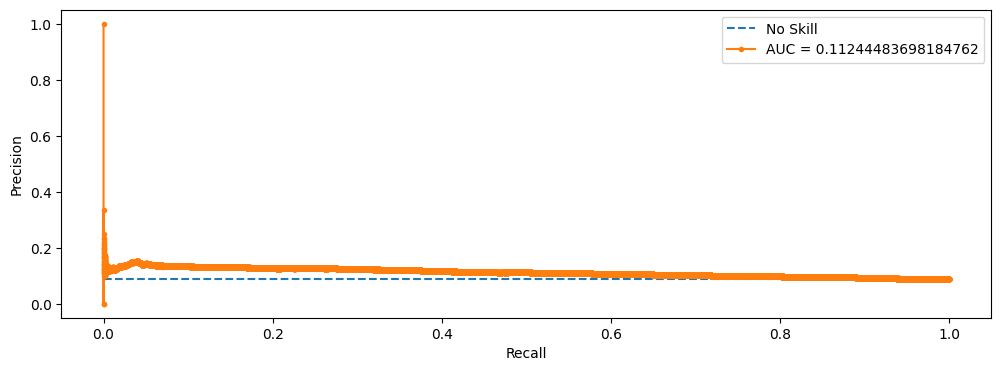

<Figure size 1200x600 with 0 Axes>

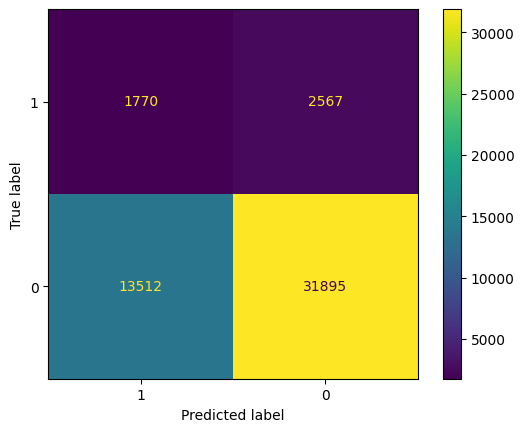

In [158]:
evaluate_model(Y_test,Y_pred_logit_adasyn_probs,Y_pred_logit_adasyn_labels,False,True)

In [ ]:
hgb_clf_adasyn = HistGradientBoostingClassifier()

In [ ]:
hgb_clf_adasyn, Y_pred_hgb_adasyn = build_model(hgb_clf_adasyn,X_train_adasyn,Y_train_adasyn,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_hgb_adasyn)

In [ ]:
xbg_adasyn = XGBClassifier()

In [ ]:
xbg_adasyn, Y_pred_xbg_adasyn = build_model(xbg_adasyn,X_train_adasyn,Y_train_adasyn,X_test,Y_test)

In [ ]:
evaluate_model(Y_test,Y_pred_xbg_adasyn)

<h4> Undersampling methods </h4>

In [140]:
random_under_sampler = under_sampling.RandomUnderSampler()

In [141]:
X_train_under_sampler, Y_train_under_sampler = random_under_sampler.fit_resample(X_train,Y_train)

In [142]:
logit_clf_undersampling = LogisticRegression()

In [144]:
logit_clf_undersampling, Y_pred_logit_undersampling_probs, Y_pred_logit_undersampling_label = build_model(logit_clf_undersampling,X_train_under_sampler,Y_train_under_sampler,X_test,Y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.61      0.64      0.74      0.63      0.39     45407
          1       0.14      0.64      0.61      0.22      0.63      0.39      4337

avg / total       0.88      0.61      0.64      0.70      0.63      0.39     49744

Weighted Recall :0.6129784496622708


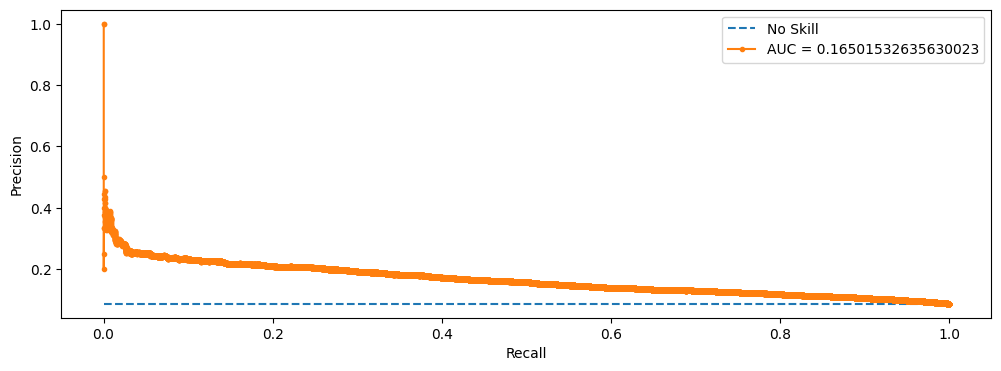

<Figure size 1200x600 with 0 Axes>

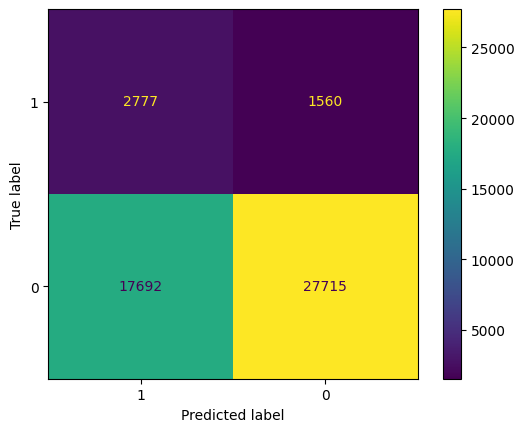

In [145]:
evaluate_model(Y_test,Y_pred_logit_undersampling_probs, Y_pred_logit_undersampling_label)

In [146]:
hgb_clf_undersampling = HistGradientBoostingClassifier()

In [147]:
hgb_clf_undersampling, Y_pred_hgb_undersampling_probs, Y_pred_hgb_undersampling_label = build_model(hgb_clf_undersampling,X_train_under_sampler,Y_train_under_sampler,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.64      0.64      0.77      0.64      0.41     45407
          1       0.15      0.64      0.64      0.24      0.64      0.41      4337

avg / total       0.88      0.64      0.64      0.72      0.64      0.41     49744

Weighted Recall :0.6422684142811192


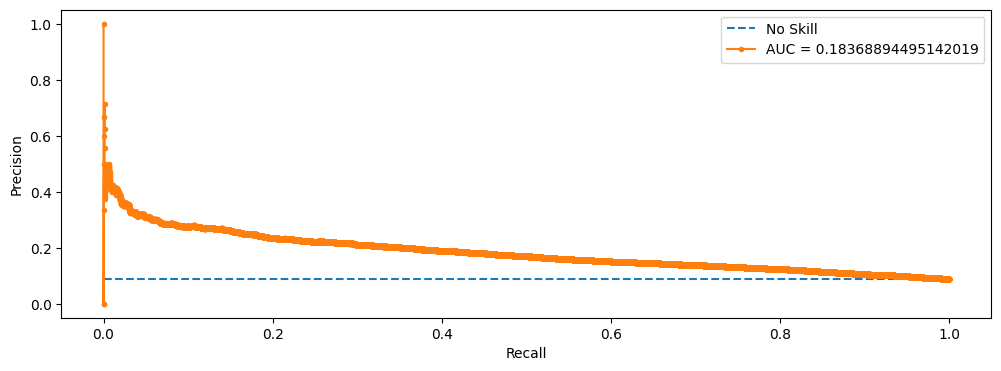

<Figure size 1200x600 with 0 Axes>

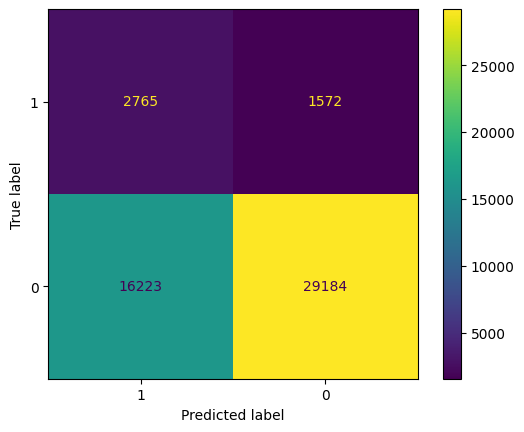

In [148]:
evaluate_model(Y_test,Y_pred_hgb_undersampling_probs, Y_pred_hgb_undersampling_label)

In [149]:
xbg_undersampling = XGBClassifier()

In [150]:
xbg_undersampling, Y_pred_xgb_undersampling_probs, Y_pred_xgb_undersampling_label  = build_model(xbg_undersampling,X_train_under_sampler,Y_train_under_sampler,X_test,Y_test)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.63      0.64      0.75      0.63      0.40     45407
          1       0.14      0.64      0.63      0.23      0.63      0.40      4337

avg / total       0.88      0.63      0.64      0.71      0.63      0.40     49744

Weighted Recall :0.6265881312319075


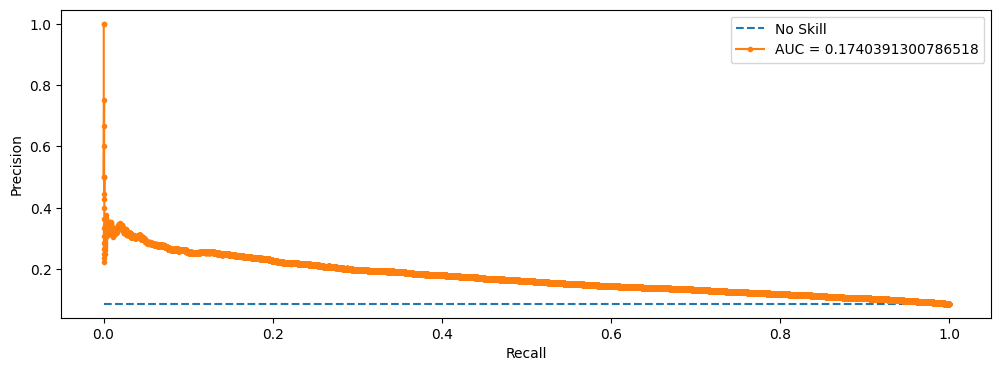

<Figure size 1200x600 with 0 Axes>

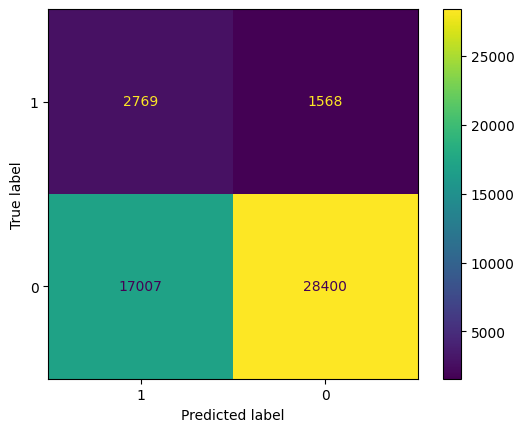

In [151]:
evaluate_model(Y_test,Y_pred_xgb_undersampling_probs, Y_pred_xgb_undersampling_label)